In [1]:
from sklearn.metrics import mean_squared_error, average_precision_score
import pandas as pd
import numpy as np
from sklearn import datasets, cluster
from sklearn.ensemble import RandomForestClassifier

import sys
sys.path.append('/Users/monte.flora/py-mint/')
sys.path.append('/Users/monte.flora/ml_workflow/')
sys.path.append('/Users/monte.flora/Desktop/road_surface/')
sys.path.append('../python_scripts')

import pymint
from pymint.main.PermutationImportance.utils import bootstrap_generator
from pymint.common.utils import to_pymint_importance, merge_dict

from joblib import delayed, Parallel, load
from display_names import storm_variables, environmental_variables, morph_vars
from calibration_classifier import CalibratedClassifier
from probsr_config import TARGET_COLUMN, PREDICTOR_COLUMNS
import itertools

In [2]:
time = 'first_hour'
opt = '' #'L1_based_feature_selection_with_manual'
targets = ['severe_wind'] #['severe_hail', 'tornado', 'severe_wind']

In [3]:
df = pd.read_pickle(f'../datasets/{time}_training_matched_to_{targets[0]}_0km_dataset')

In [4]:
storm_features=[]
env_features=[]
morph_features=[]
for var in df.columns:
    name = var.split('_ens')[0].split('_time')[0]
    if name in storm_variables:
        storm_features.append(var)
    elif name in environmental_variables:
        env_features.append(var)
    elif name in morph_vars:
        morph_features.append(var)

In [5]:
# Intra-Storm vs. Environmental vs. Morphological 
groups_wofs = {
          'Intra-Storm' : storm_features, 
          'Environmental' : env_features, 
          'Morphological' : morph_features,
         }

feature_colors = {'Intra-Storm' : 'lightgreen',
                  'Environmental' : 'peachpuff', 
                  'Morphological' : 'lightblue',
                  'Temperature-Based' : 'lightgreen',
                  'Radiation-Based' : 'lightblue',
                 }

In [6]:
groups_rs = {'Temperature-Based': ['dwpt2m','sfcT_hrs_ab_frez', 'sfcT_hrs_bl_frez', 'sfc_temp', 
                                   'temp2m', 'tmp2m_hrs_ab_frez', 'tmp2m_hrs_bl_frez', 'hrrr_dT'],
             
             'Radiation-Based' : ['gflux', 'high_cloud','lat_hf', 'low_cloud', 'mid_cloud', 'sat_irbt', 'sens_hf', 
                                  'tot_cloud', 'uplwav_flux', 'vbd_flux', 'vdd_flux', 
                                  'd_ground','d_rad_d','d_rad_u']
            }

In [7]:
targets = ['road_surface', 'tornado', 'severe_wind', 'severe_hail']
methods = ['grouped', 'grouped_only']

for target, perm_method in itertools.product(targets, methods):
    if target == 'road_surface':
        df = pd.read_csv('../datasets/probsr_training_data.csv')
        model_fname = '../models/JTTI_ProbSR_RandomForest.pkl'
        calibrator_fname = '../models/JTTI_ProbSR_RandomForest_Isotonic.pkl'
        
        base_estimator = load(model_fname)
        calibrator = load(calibrator_fname)
        model = CalibratedClassifier(base_estimator, calibrator)
        
        X = df[PREDICTOR_COLUMNS]
        y = df[TARGET_COLUMN]
        estimator_name = 'LR'
        groups = groups_rs
    else:
        df = pd.read_pickle(f'../datasets/{time}_training_matched_to_{target}_0km_dataset')
        model_fname = f'../models/LogisticRegression_first_hour_{target}_under_standard_{opt}.pkl'
        data = load(model_fname)
        features = data['features']
        model = data['model']
        X, y = df[features], df[f'matched_to_{target}_0km'].values.astype(float)
        estimator_name = 'LR'
        groups = groups_wofs
    
    estimators = (estimator_name, model)
    explainer = pymint.InterpretToolkit(estimators, X=X, y=y)

    scores = explainer.grouped_permutation_importance(evaluation_fn='norm_aupdc',
                                                  perm_method = perm_method,
                                            groups=groups, 
                                            n_permute=1,
                                            subsample=0.1,
                                            )
    explainer.save(data=scores, fname=f'../datasets/{perm_method}_importance_{target}.nc')
    
    print(f'Done with {target}!')

Done with road_surface!
Done with road_surface!
Done with tornado!
Done with tornado!
Done with severe_wind!
Done with severe_wind!
Done with severe_hail!
Done with severe_hail!


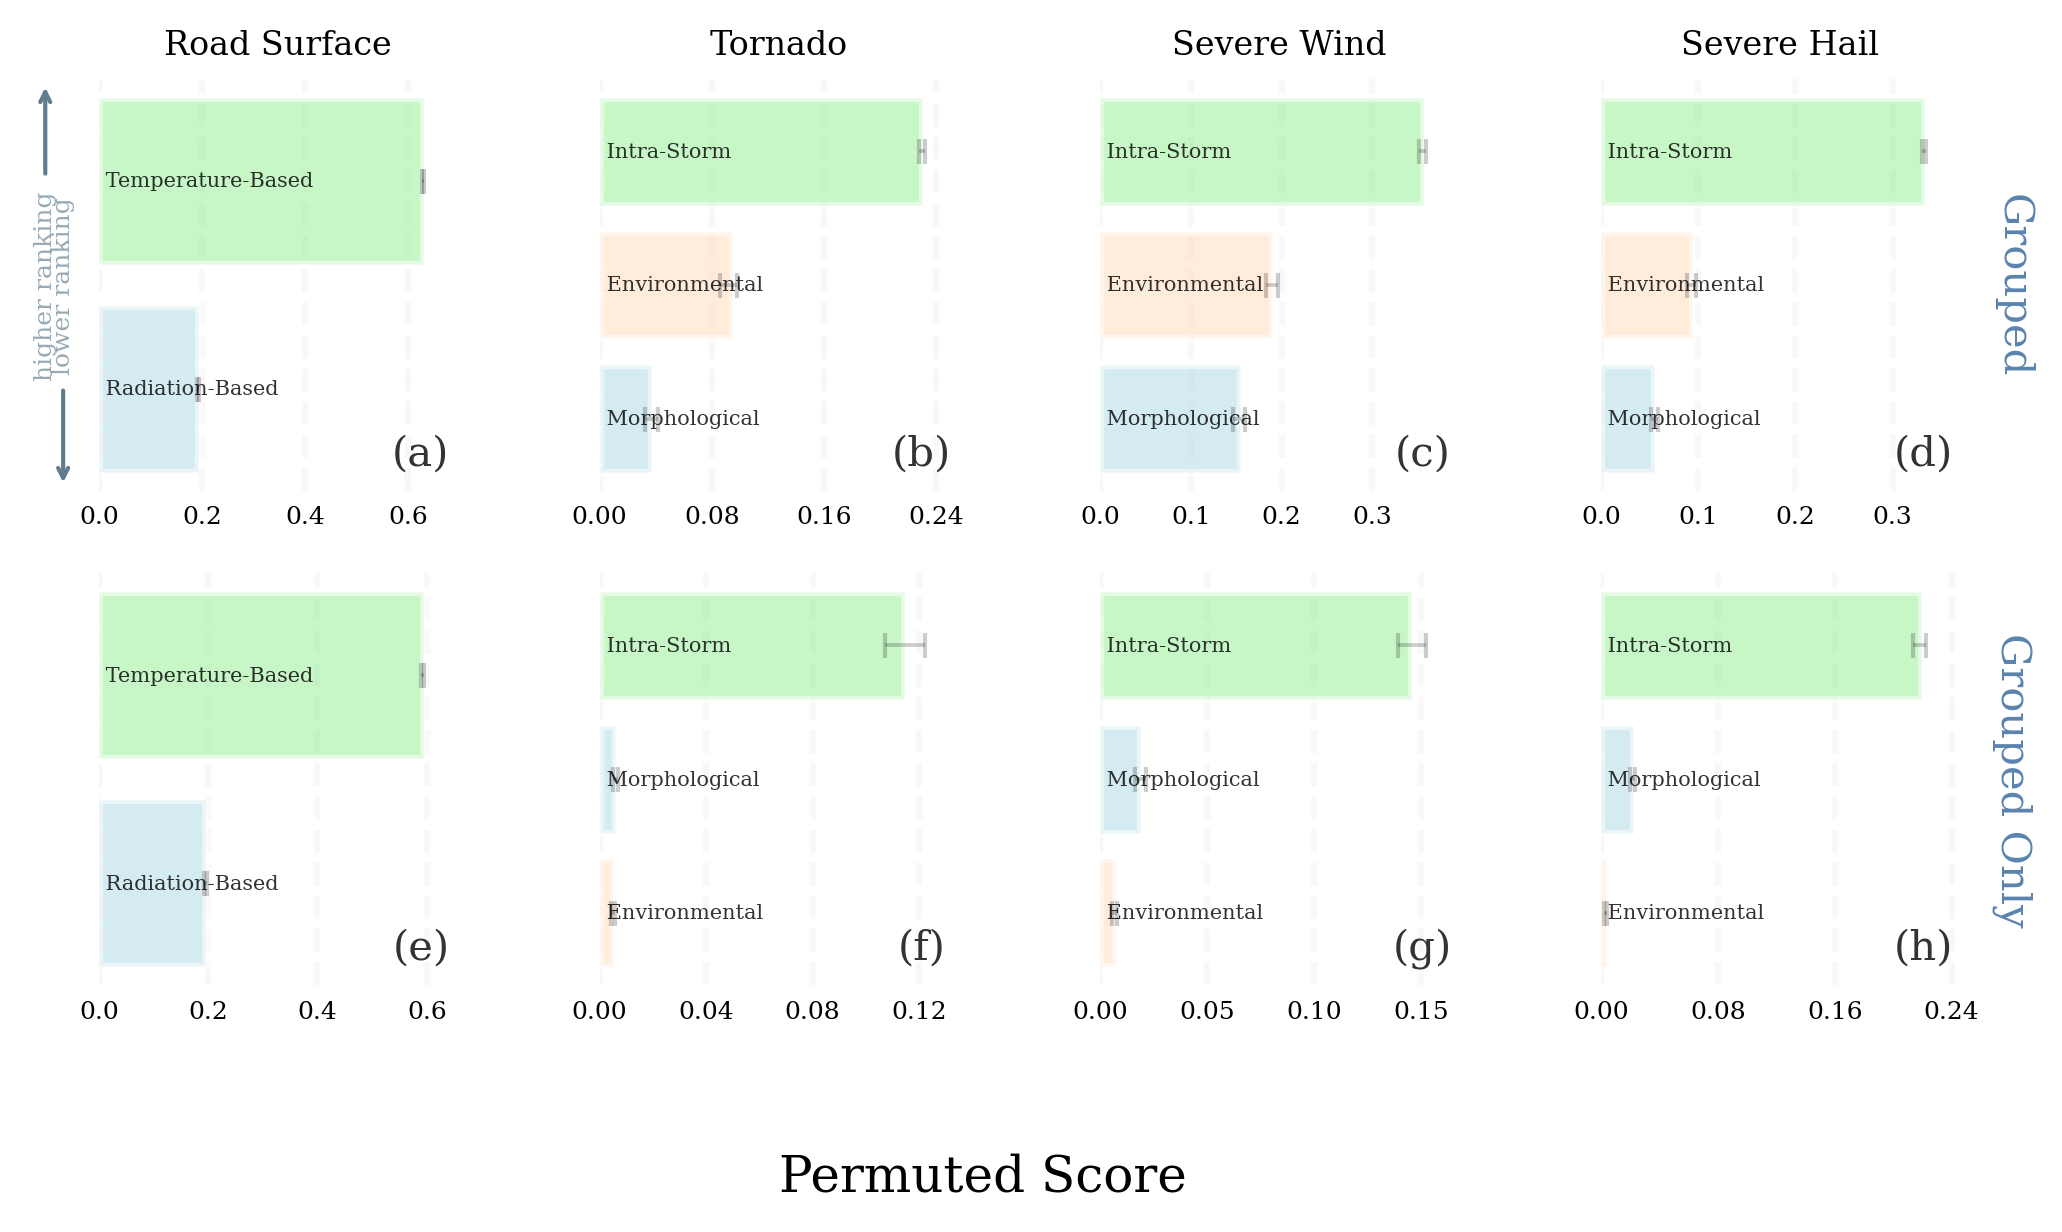

In [18]:
targets = ['road_surface', 'tornado', 'severe_wind', 'severe_hail']
methods = ['grouped', 'grouped_only']


feature_colors = {'Intra-Storm' : 'lightgreen',
                  'Environmental' : 'peachpuff', 
                  'Morphological' : 'lightblue',
                  'Temperature-Based' : 'lightgreen',
                  'Radiation-Based' : 'lightblue',
                 }

explainer = pymint.InterpretToolkit()
data = []
for perm_method,target in itertools.product(methods, targets):
    data.append( explainer.load(f'../datasets/{perm_method}_importance_{target}.nc') )

    
panels = [('grouped', 'LR'), ('grouped', 'LR'),('grouped', 'LR'),('grouped', 'LR'),
          ('grouped_only', 'LR'), ('grouped_only', 'LR'),('grouped_only', 'LR'),('grouped_only', 'LR'), 
         ]   
    
f, axes = explainer.plot_importance(data=data, 
                                    panels = panels, 
                                    feature_colors = feature_colors, 
                                   n_columns=4, 
                                   ylabels = ['Grouped', 'Grouped Only'],
                                   xlabels=['']*8,
                                    hspace=0.2,
                                    figsize = (8,4)
                                   )

axes[1,1].annotate('Permuted Score', (0.5, -0.5), xycoords='axes fraction')


titles = ['Road Surface', 'Tornado', 'Severe Wind', 'Severe Hail']

for ax, title in zip(axes.flat, titles):
        ax.set_title(title)

In [ ]:
data[1]

In [ ]:
mid_level_vars = ['shear_u_0to6', 'shear_v_0to6', 'th_e_ml', 'mid_level_lapse_rate', 
                  'temperature_700mb', 'temperature_500mb', 'geopotential_height_700mb',
                   'geopotential_height_500mb', 'dewpoint_700mb','dewpoint_500mb',
                   'uh_2to5', 'w_up', 'dbz_3to5km_max', 'hailcast', 
                 ]

low_level_vars = ['srh_0to1','srh_0to3', 'shear_u_0to1', 'shear_v_0to1', 'u_10', 'v_10', 
                 'low_level_lapse_rate', 'temperature_850mb', 'geopotential_height_850mb', 'dewpoint_850mb'
                 'uh_0to2', 'wz_0to2', 'ws_80', 'w_1km','w_down', '10-m_bulk_shear','divergence_10m',
                  'bouyancy', 'dbz_1to3km_max',]

In [ ]:
mid_features=[]
low_features=[]
for var in df.columns:
    name = var.split('_ens')[0].split('_time')[0]
    if name in mid_level_vars:
        mid_features.append(var)
    elif name in low_level_vars:
        low_features.append(var)

In [ ]:
groups = {
          'Mid-Level' : mid_features, 
          'Low-Level' : low_features, 
         }

In [ ]:
for target in targets:
    model_fname = f'../models/LogisticRegression_first_hour_{target}_under_standard_{opt}.pkl'
    
    data = load(model_fname)
    features = data['features']
    model = data['model']

    X, y = df[features], df[f'matched_to_{target}_0km'].values.astype(float)
    estimators = ('LR', model)
    explainer = pymint.InterpretToolkit(estimators, X=X, y=y)

    scores = explainer.grouped_permutation_importance(evaluation_fn='norm_aupdc',
                                                  perm_method = 'grouped_only',
                                            groups=groups, 
                                            n_permute=5,
                                            subsample=0.25,
                                            )
    explainer.plot_importance(data=scores, 
                         panels = [('grouped_only', 'LR')],
                         ) 